# Object Detection Example

## Introduction

In this notebook, we'll walk through a detailed example of how you can use Valor to evaluate object detections made on [the COCO Panoptic dataset](https://cocodataset.org/#home). We'll use Ultralytics' `YOLOv8` model to predict what objects exist in various COCO photographs and compare performance between bounding box and image segmentation results.

For a conceptual introduction to Valor, [check out our project overview](https://striveworks.github.io/valor/). For a higher-level example notebook, [check out our "Getting Started" notebook](https://github.com/Striveworks/valor/blob/main/examples/getting_started.ipynb).

## Defining Our Datasets

We start by fetching our dataset and uploading it to Valor.

In [1]:
%matplotlib inline

import os
import json
import builtins
import requests

from tqdm import tqdm
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from valor_lite.object_detection import DataLoader, MetricType

In [2]:
def download_data_if_not_exists(
    file_name: str,
    file_path: Path,
    url: str,
):
    """Download the data from a public bucket if it doesn't exist locally."""

    if not os.path.exists(file_path):
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get("content-length", 0))
            with open(file_path, "wb") as f:
                with tqdm(
                    total=total_size,
                    unit="B",
                    unit_scale=True,
                    unit_divisor=1024,
                    desc=file_name,
                ) as pbar:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
                            pbar.update(1024)
        else:
            raise RuntimeError(response)
    else:
        print(f"{file_name} already exists locally.")

    # sort file by datum uid
    with open(file_path, "r") as f:
        lines = [x for x in f]
    with open(file_path, "w") as f:
        for line in sorted(
            lines, key=lambda x: int(json.loads(x)["datum"]["uid"])
        ):
            f.write(line)

groundtruth_file = "gt_objdet_coco_bbox.jsonl"
prediction_file = "pd_objdet_yolo_bbox.jsonl"

# cache data locally
current_directory = Path(os.getcwd())
for filename in [groundtruth_file, prediction_file]:
    file_path = current_directory / Path(filename)
    url = f"https://pub-fae71003f78140bdaedf32a7c8d331d2.r2.dev/{filename}"
    download_data_if_not_exists(
        file_name=filename, file_path=file_path, url=url
    )

gt_path = current_directory / Path(groundtruth_file)
pd_path = current_directory / Path(prediction_file)

gf = builtins.open(gt_path, "r")
groundtruths = [
    json.loads(gline)
    for gline in gf
]
gf.close()

pf = builtins.open(pd_path, "r")
predictions = [
    json.loads(pline)
    for pline in pf
]
pf.close()

gt_objdet_coco_bbox.jsonl already exists locally.
pd_objdet_yolo_bbox.jsonl already exists locally.


# Creating an Evaluator

This block utilizes `get_instance_groundtruths` from `integrations/coco_integration.py` to download, extract, and upload the COCO Panoptic validation dataset to Valor.

In [3]:
loader = DataLoader()
loader.add_bounding_boxes_from_valor_dict(zip(groundtruths, predictions), show_progress=True)
evaluator = loader.finalize()

5000it [00:00, 5733.27it/s]


In [4]:
evaluator.metadata

{'n_datums': 5000,
 'n_groundtruths': 36536,
 'n_predictions': 27092,
 'n_labels': 159,
 'ignored_prediction_labels': ['tv',
  'chair',
  'person',
  'clock',
  'refrigerator',
  'potted plant',
  'vase',
  'dining table',
  'bear',
  'bed',
  'bottle',
  'stop sign',
  'teddy bear',
  'skis',
  'oven',
  'tennis racket',
  'sports ball',
  'handbag',
  'bird',
  'cell phone',
  'sandwich',
  'cup',
  'mouse',
  'laptop',
  'keyboard',
  'car',
  'truck',
  'traffic light',
  'bus',
  'cat',
  'airplane',
  'zebra',
  'apple',
  'baseball bat',
  'wine glass',
  'bowl',
  'knife',
  'spoon',
  'snowboard',
  'backpack',
  'banana',
  'donut',
  'broccoli',
  'skateboard',
  'bench',
  'carrot',
  'couch',
  'book',
  'remote',
  'tie',
  'surfboard',
  'toilet',
  'orange',
  'sheep',
  'train',
  'baseball glove',
  'elephant',
  'frisbee',
  'umbrella',
  'horse',
  'kite',
  'microwave',
  'cake',
  'motorcycle',
  'fork',
  'pizza',
  'cow',
  'dog',
  'fire hydrant',
  'bicycle',


## Evaluating Performance

With our `Dataset` and `Model` defined, we're ready to evaluate our performance and display the results. Note that we use the `wait_for_completion` method since all evaluations run as background tasks; this method ensures that the evaluation finishes before we display the results.

Sometimes, we may only want to calculate metrics for a subset of our data (i.e., we may only want to see how well our model performed at a specific type of detection). To accomplish this task, we can use the `filters` parameter of `evaluation_detection` to specify what types of data to evaluate performance for.

We will be running and comparing two different evaluations investigating the performance difference of YOLOv8's bounding box and raster outputs.

In [5]:
metrics = evaluator.compute_metrics(
    iou_thresholds=[0.25],
)

### Average Precision (AP)

In [6]:
metrics[MetricType.AP]

[AP(value=0.0, iou_threshold=0.25, label='name_person'),
 AP(value=0.0, iou_threshold=0.25, label='name_chair'),
 AP(value=0.0, iou_threshold=0.25, label='name_potted plant'),
 AP(value=0.0, iou_threshold=0.25, label='name_dining table'),
 AP(value=0.0, iou_threshold=0.25, label='name_tv'),
 AP(value=0.0, iou_threshold=0.25, label='name_microwave'),
 AP(value=0.0, iou_threshold=0.25, label='name_refrigerator'),
 AP(value=0.0, iou_threshold=0.25, label='name_book'),
 AP(value=0.0, iou_threshold=0.25, label='name_clock'),
 AP(value=0.0, iou_threshold=0.25, label='name_vase'),
 AP(value=0.0, iou_threshold=0.25, label='name_bear'),
 AP(value=0.0, iou_threshold=0.25, label='name_bed'),
 AP(value=0.0, iou_threshold=0.25, label='name_car'),
 AP(value=0.0, iou_threshold=0.25, label='name_truck'),
 AP(value=0.0, iou_threshold=0.25, label='name_stop sign'),
 AP(value=0.0, iou_threshold=0.25, label='name_teddy bear'),
 AP(value=0.0, iou_threshold=0.25, label='name_skis'),
 AP(value=0.0, iou_thres

### Mean Average Precision (mAP)

In [7]:
metrics[MetricType.mAP]

[mAP(value=0.0, iou_threshold=0.25)]

### Precision-Recall Curve

/tmp/ipykernel_9692/1273825816.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


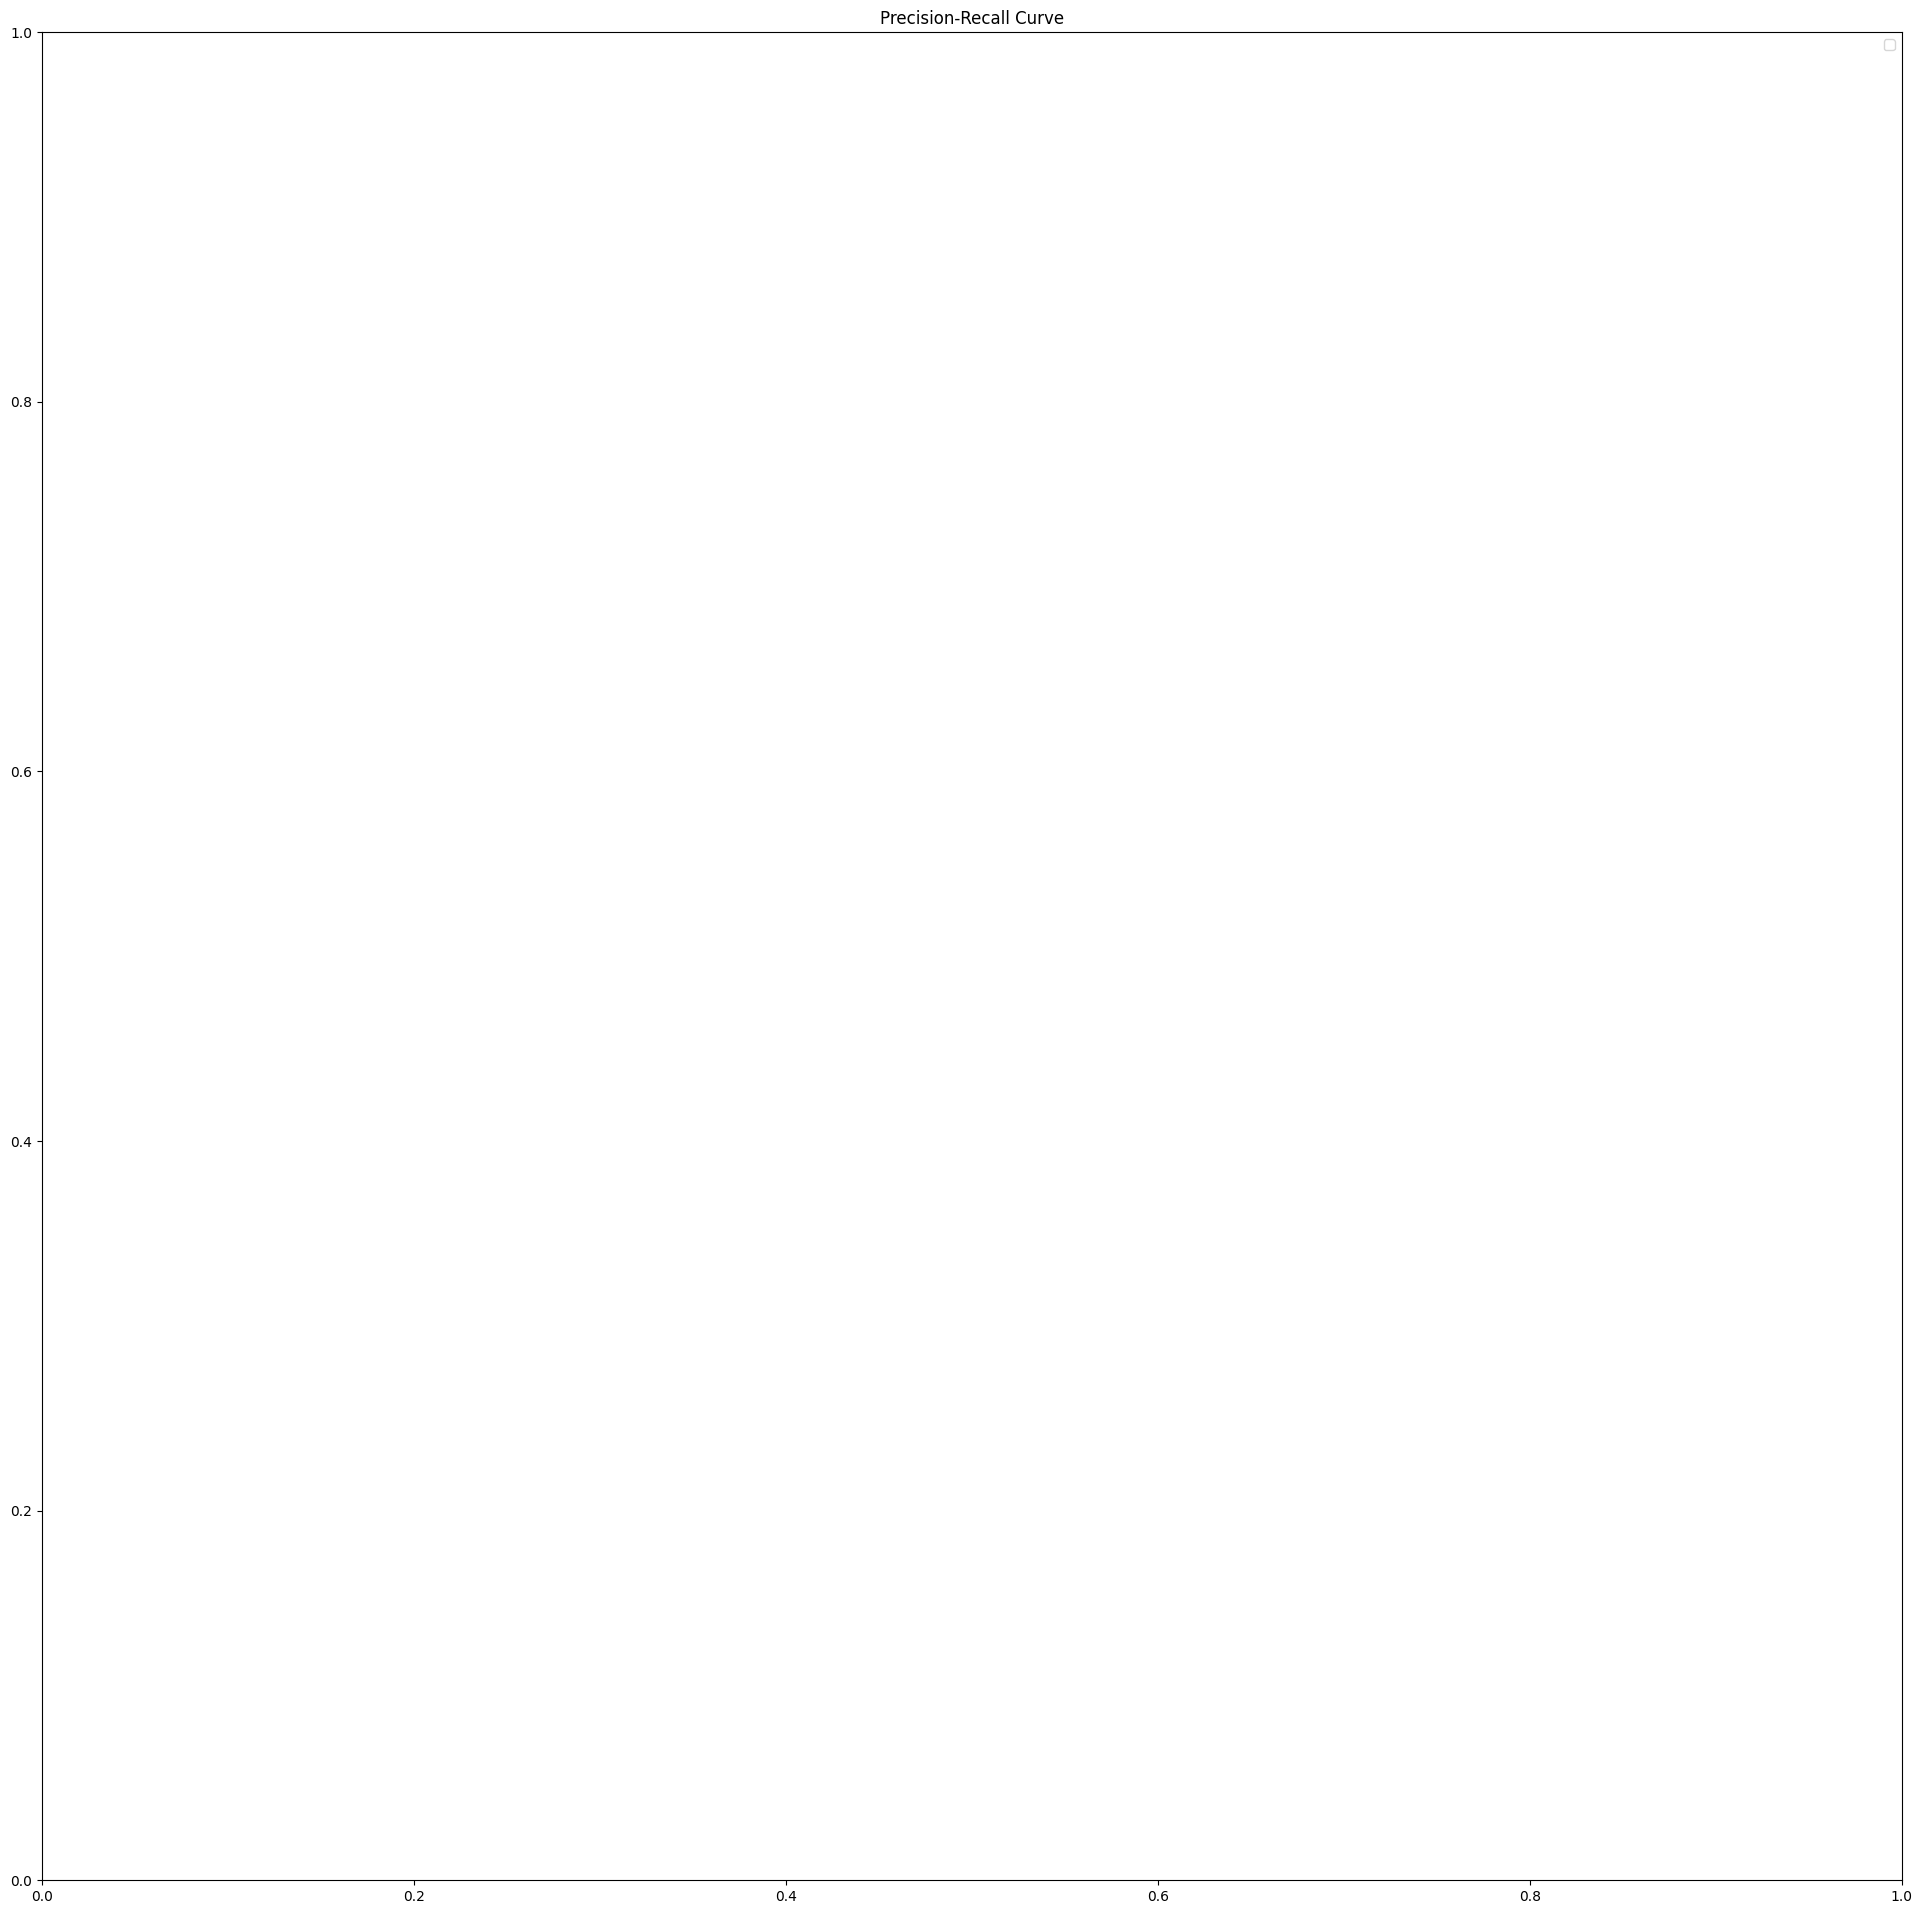

In [8]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
recall = [x / 100 for x in range(0,101)]
for curve in metrics[MetricType.PrecisionRecallCurve]:
    if curve.label[0] != "name":
        continue
    plt.plot(recall, curve.precision, label=curve.label[1])
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

### Confusion Matrix

In [9]:
matrices = evaluator.compute_confusion_matrix(
    score_thresholds=[0.25],
    iou_thresholds=[0.25],
)
metric = matrices[0]

AttributeError: 'ConfusionMatrix' object has no attribute 'label_key'

In [ ]:
cm = {
    gt: {
        pd: metric.confusion_matrix[gt][pd]["count"]
        for pd in metric.confusion_matrix[gt]
    }
    for gt in metric.confusion_matrix
}
pd.DataFrame(cm)

### Hallucinations

In [ ]:
metric.hallucinations

### Ground Truths Missing Predictions

In [ ]:
metric.missing_predictions